# EEG Decoding Pipeline Script with Balancing and Epoch Filtering

This script implements the complete EEG decoding pipeline that includes functions to balance classes, filter out invalid epochs, and run cross-validation using an LDA classifier on P300 ERP features.
- Note: The hyperparameter discard_threshold = 10 helps to filter out trials with too few epochs (which may be unreliable for correlation-based decision-making), and this value should be informed by something.*

---

## Function Descriptions

### 1. `balance_classes`
**Purpose:**  
Sub-selects samples from the feature matrix (`X`) and corresponding labels (`y`) to achieve a specified ratio of class 0s to 1s, while preserving the original order.

**Parameters:**
- `X` (numpy.ndarray): Feature matrix of shape `(n_samples, n_features)`.
- `y` (numpy.ndarray): Label vector of shape `(n_samples,)`.
- `ratio_0_to_1` (float, default=1.0): Desired ratio of 0s to 1s in the balanced dataset.

**Returns:**
- `X_balanced`, `y_balanced`: The sub-selected feature matrix and label vector based on the specified ratio.

---

### 2. `filter_valid_epochs`
**Purpose:**  
Filters out epochs where the feature vectors (`X`) or the labels (`y`) contain NaN values. If a third array (`z`) is provided, it is filtered similarly.

**Parameters:**
- `X` (numpy.ndarray): Feature matrix with shape `(n_epochs, n_features)`.
- `y` (numpy.ndarray): Label vector with shape `(n_epochs,)`.
- `z` (numpy.ndarray, optional): An additional array to filter using the same mask.
- `return_mask` (bool, optional): If `True`, returns the boolean mask of valid epochs.

**Returns:**
- `filtered_X`, `filtered_y`, `filtered_z`: Filtered data and labels.
- Optionally, the valid-mask (if `return_mask=True`).

---

## Workflow Overview

The main script performs the following steps for each subject:
  
1. **Data Loading:**
   - Loads a `.npz` file containing the pre-extracted P300 features for each subject. The file includes:
     - `X`: Feature matrix with dimensions `(n_trials, n_channels, n_samples)`.
     - `y`: Labels indicating the cued side for each trial.
     - `z`: Array indicating target presence (with shape `(n_trials, n_epochs, sides)`).
     - `fs`: Sampling frequency.
     
2. **Cross-Validation Setup:**
   - Splits the data into training and testing sets using 4-fold cross-validation.
   - Computes the number of trials per fold.

3. **Training Data Preparation:**
   - **Flattening:** Training trials are reshaped into epochs (flattening trials and epochs into a 2D array).
   - **Label Extraction:** Training epoch labels are extracted using the `z` array and the cued side provided in `y`.
   - **Filtering:** Invalid epochs (those with NaNs) are removed using `filter_valid_epochs`.
   - **Optional** Classes are balanced using `balance_classes` if desired.

4. **Testing Data Preparation:**
   - Similar flattening is performed for testing trials.
   - Epoch labels and additional target arrays (`z`) are extracted.
   - The `filter_valid_epochs` function is applied to remove epochs with NaNs.
   - The mask returned by `filter_valid_epochs` is used to rebuild the trial structure and count the number of valid epochs per trial.

5. **Model Training and Evaluation:**
   - An LDA classifier (configured with a Ledoit-Wolf covariance estimator) is trained on the valid training epochs.
   - For each testing trial, if the number of valid epochs is above a threshold (`discard_threshold`), the script:
     - Computes decision scores using LDA.
     - Evaluates performance via precision-recall AUC and a decision rule based on the correlation between scores and target values.
     - Counts correctly inferred trials based on the cued side.

6. **Results Aggregation and Saving:**
   - For each fold, performance metrics (PR-AUC and trial-level accuracy) are computed.
   - Metrics are aggregated over folds and then over subjects.
   - The overall results are saved as a structured NumPy array in a results file.

7. **Logging:**
   - The script logs the number of discarded trials (those with too few valid epochs) and prints overall performance metrics.

---


## Trial-level Inference, subject-resolved

In [1]:
import os
from os.path import join
import numpy as np
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import precision_recall_curve, auc
from sklearn.covariance import OAS
import warnings
from toeplitzlda.classification import ToeplitzLDA
warnings.filterwarnings("ignore")

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))

analysis_dir = join(data_dir, "analysis")
p300_dir = join(analysis_dir, "p300")
decoding_results_dir = join(p300_dir, "decoding_results") 
plots_dir = join(p300_dir, "plots", "decoding")
features_dir = join(p300_dir, "plots", "features")

subjects = ["VPpdia","VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig","VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix","VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]


In [2]:
def balance_classes(X, y, ratio_0_to_1=1.0):
    
    """
    Sub-select X and y based on a specified ratio of 0s to 1s, keeping the original order.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features).
    y (numpy.ndarray): Label vector of shape (n_samples,).
    ratio_0_to_1 (float): The desired ratio of 0s to 1s in the balanced dataset.

    Returns:
    X_balanced, y_balanced: Sub-selected feature matrix and label vector.
    """
    # Step 1: Identify indices of 0s and 1s
    indices_0 = np.where(y == 0)[0]
    indices_1 = np.where(y == 1)[0]
    
    # Step 2: Calculate the number of samples to select for each class
    num_1s = len(indices_1)
    num_0s = min(len(indices_0), int(num_1s * ratio_0_to_1))
    
    # Step 3: Randomly sample the desired number of 0s and 1s
    selected_indices_0 = np.random.choice(indices_0, num_0s, replace=False)
    selected_indices_1 = np.random.choice(indices_1, num_1s, replace=False)
    
    # Step 4: Combine selected indices and sort to preserve original order
    balanced_indices = np.sort(np.concatenate([selected_indices_0, selected_indices_1]))
    
    # Step 5: Sub-select X and y based on the balanced indices
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    return X_balanced, y_balanced

In [3]:
def filter_valid_epochs(X, y, z=None, return_mask=False):
    """
    Filters out epochs where either the features in X or the labels in y contain NaN values.
    Optionally, if a z array is provided, it is filtered similarly.
    
    Parameters:
        X (np.ndarray): A 2D numpy array with shape (n_epochs, n_features).
        y (np.ndarray): A 1D numpy array with shape (n_epochs,).
        z (np.ndarray, optional): An array that will be filtered using the same mask.
        return_mask (bool, optional): If True, the boolean mask used for filtering is returned.
    
    Returns:
        filtered_X (np.ndarray): X with only rows that have no NaN values.
        filtered_y (np.ndarray): y with only entries corresponding to valid epochs.
        filtered_z (np.ndarray or None): Filtered z array (if provided) or None.
        mask (np.ndarray, optional): The boolean mask of valid epochs; only returned if return_mask=True.
    """
    # Create a mask for valid labels and features
    valid_label_mask = ~np.isnan(y)
    valid_feature_mask = ~np.isnan(X).any(axis=1)
    combined_mask = valid_label_mask & valid_feature_mask

    # Apply the mask to X and y
    filtered_X = X[combined_mask]
    filtered_y = y[combined_mask]
    
    if z is not None:
        filtered_z = z[combined_mask]
    else:
        filtered_z = None

    if return_mask:
        return filtered_X, filtered_y, filtered_z, combined_mask
    else:
        return filtered_X, filtered_y, filtered_z

In [4]:
# -- Parameters -- 
discard_threshold = 20
do_balance_classes = True
ratio_0_to_1 = 5
# load .._p300_features for NaN-marked feature matrix
# and .._p300_features_noreject for non-marked feature matrix

discarded_trials = []
results_decoding = {"subjects": []}
task = 'covert'
for subject in subjects:
    file_dir = os.path.join(derivatives_dir, 'features', "p300", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_p300_features_wo_bc_64_ica.npz")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

     # Load the data from the NPZ file
    npz_data = np.load(file_path)
    # Extract data
    X = npz_data['X']  # EEG data: trials x epochs x channels x features
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides
    # Channel count
    n_channels = X.shape[2]
    # Cross-validation setup
    n_folds = 4
    n_trials = int(X.shape[0] / n_folds)
    folds = np.repeat(np.arange(n_folds), n_trials)

    fold_pr_auc = []
    fold_correct_trials = []

    # Cross-validation loop alike in pyntbci
    discarded_trial_counter = 0
    for i_fold in range(n_folds):
    # Split into train and test sets
        X_trn_trials, y_trn_trials, z_trn_trials = X[folds != i_fold], y[folds != i_fold], z[folds != i_fold]
        X_tst_trials, y_tst_trials, z_tst_trials = X[folds == i_fold], y[folds == i_fold], z[folds == i_fold]
        
        ### TRAINING
        # Flatten training trials into epochs: shape becomes [n_trials * epochs, channel * features]
        X_trn_epochs = X_trn_trials.transpose((0,1,3,2)).reshape(-1, X_trn_trials.shape[2] * X_trn_trials.shape[3])
        
        # Extract labels for training epochs using z and y 
        trial_indices_trn = np.arange(len(y_trn_trials))  # indices for trials
        y_trn_epochs = z_trn_trials[trial_indices_trn, :, y_trn_trials].reshape(-1)
        
        # Filter training epochs
        X_trn_epochs, y_trn_epochs, _ = filter_valid_epochs(X_trn_epochs, y_trn_epochs)
        
        # Balance training classes
        if do_balance_classes:
            X_trn_epochs, y_trn_epochs = balance_classes(X_trn_epochs, y_trn_epochs, ratio_0_to_1=ratio_0_to_1)
        
        # Sanity check for training data
        if np.isnan(X_trn_epochs).any() or np.isnan(y_trn_epochs).any():
            raise ValueError("NaNs found in training epochs after filtering!")
        
        ## Fit LDA
        lda = ToeplitzLDA(n_channels=n_channels)
        #lda = LDA(solver="lsqr", covariance_estimator=OAS())
        # Dimensionality bust be 2
        lda.fit(X_trn_epochs, y_trn_epochs)

        ### TESTING
        # Flatten testing trials into epochs
        X_tst_epochs = X_tst_trials.transpose((0,1,3,2)).reshape(-1, X_tst_trials.shape[2] * X_tst_trials.shape[3])
        
        # Extract labels for testing epochs (again, using z and y for indexing)
        trial_indices_tst = np.arange(len(y_tst_trials))
        y_tst_epochs = z_tst_trials[trial_indices_tst, :, y_tst_trials].reshape(-1)
        
        # Reshape z_tst_trials into epochs.
        z_tst_epochs = z_tst_trials.reshape(len(y_tst_trials) * z_tst_trials.shape[1], 2)
        
        # Filter testing epochs and also retrieve the original mask so we can count epochs per trial
        X_tst_epochs, y_tst_epochs, z_tst_epochs, combined_mask_tst = filter_valid_epochs(
            X_tst_epochs, y_tst_epochs, z=z_tst_epochs, return_mask=True
        )
        
        # Calculate the number of preserved epochs per trial for testing.
        # Here, combined_mask_tst still has the original shape before filtering.
        # Reshape it to [n_trials, epochs_per_trial] and sum True values per trial.
        epoch_counts = combined_mask_tst.reshape(len(y_tst_trials), -1)
        num_epochs = np.sum(epoch_counts, axis=1)
        
        # Rebuild trial structure for testing data based on num_epochs
        nested_X_tst_trials = []
        nested_z_tst_epochs = []
        start_idx = 0
        for trial_idx, n_ep in enumerate(num_epochs):
            end_idx = start_idx + n_ep
            nested_X_tst_trials.append(X_tst_epochs[start_idx:end_idx])
            nested_z_tst_epochs.append(z_tst_epochs[start_idx:end_idx])
            start_idx = end_idx
        

        # Evaluate model on test data
        correct_trials = 0
        
        for t_idx in range(len(y_tst_trials)):

            num_preserved_epochs = num_epochs[t_idx]
            if num_preserved_epochs < discard_threshold:
                discarded_trial_counter +=1
                continue
            
            # Log cued side informed by y_tst
            cued_side = y_tst_trials[t_idx]
            # create event vectors & ground truth
            left_targets = nested_z_tst_epochs[t_idx][:, 0]
            right_targets = nested_z_tst_epochs[t_idx][:, 1]
            cued_targets = nested_z_tst_epochs[t_idx] [:, cued_side]
            
   
            # Compute LDA scores for epochs
            epoch_scores = lda.decision_function(nested_X_tst_trials[t_idx])
            
            # Log performance per fold
            precision, recall, _ = precision_recall_curve(cued_targets, epoch_scores)
            pr_auc_score = auc(recall, precision)
            fold_pr_auc.append(pr_auc_score)

            # Correlation-based decision
            corr_left, _ = pearsonr(epoch_scores, left_targets)
            corr_right, _ = pearsonr(epoch_scores, right_targets)

            # Triel-level decision rule based on correlation
            decision = 0 if corr_left > corr_right else 1
            if decision == cued_side:
                correct_trials += 1
        
        fold_correct_trials.append(correct_trials)
    discarded_trials.append([subject, discarded_trial_counter/ n_folds])
    # Compute perf metrics
    pr_auc_mean = np.mean(fold_pr_auc)
    pr_auc_se = np.std(fold_pr_auc, ddof=1) / np.sqrt(len(fold_pr_auc))
    correct_trials_mean = np.mean(fold_correct_trials) / (y.size / n_folds)
    correct_trials_se = np.std(fold_correct_trials, ddof=1) / np.sqrt(len(fold_correct_trials)) / (y.size / n_folds)
     
     # --- Prepare Data for saving ---
    # Store results
    results_decoding["subjects"].append({
        "subject_id": subject,
        "pr_auc_mean": pr_auc_mean,
        "pr_auc_se": pr_auc_se,
        "correct_trials_mean": correct_trials_mean,
        "correct_trials_se": correct_trials_se
    })
    # --- Add Aggregate (Overall) Results Before Saving ---
pr_auc_means = [subj['pr_auc_mean'] for subj in results_decoding["subjects"]]
correct_trials_means = [subj['correct_trials_mean'] for subj in results_decoding["subjects"]]

overall_result = {
    "subject_id": "Overall",
    "pr_auc_mean": np.mean(pr_auc_means),
    "pr_auc_se": np.std(pr_auc_means, ddof=1) / np.sqrt(len(pr_auc_means)),
    "correct_trials_mean": np.mean(correct_trials_means),
    "correct_trials_se": np.std(correct_trials_means, ddof=1) / np.sqrt(len(correct_trials_means))
}
results_decoding["subjects"].append(overall_result)

# Convert results to a structured NumPy array for saving
dtype = [
    ('subject_id', 'U10'),   # Unicode string (max length 10)
    ('pr_auc_mean', 'f8'),
    ('pr_auc_se', 'f8'),
    ('correct_trials_mean', 'f8'),
    ('correct_trials_se', 'f8')
]
structured_array = np.array(
    [
        (
            subj['subject_id'],
            subj['pr_auc_mean'],
            subj['pr_auc_se'],
            subj['correct_trials_mean'],
            subj['correct_trials_se']
        )
        for subj in results_decoding['subjects']
    ],
    dtype=dtype
)

# Save the structured array
if not os.path.exists(decoding_results_dir):
    os.makedirs(decoding_results_dir)
np.save(join(decoding_results_dir, f"{task}_lda_p300_results.npy"), structured_array)

# --- Print Overall Metrics ---
overall_pr_auc_mean = overall_result['pr_auc_mean']
overall_pr_auc_se = overall_result['pr_auc_se']
overall_accuracy_mean = overall_result['correct_trials_mean']
overall_accuracy_se = overall_result['correct_trials_se']

print(f"Overall LDA PR-AUC: {overall_pr_auc_mean:.2f} ± {overall_pr_auc_se:.2f}")
print(f"Overall trial level inference accuracy: {overall_accuracy_mean:.2f} ± {overall_accuracy_se:.2f}")

# --- Log Discarded Trials ---

discarded_trials_log = [(subj, val) for subj, val in discarded_trials if val > (1 / 4)] # account for fold-average
if discarded_trials_log:
    print(f"Trials discarded (< {discard_threshold} epochs available for integration) for the following subjects (fold-average):")
    for subj, val in discarded_trials_log:
        print(f"Subject: {subj}, Discarded Trials: {val}")
else:
    print("No trials discarded.")

Overall LDA PR-AUC: 0.68 ± 0.02
Overall trial level inference accuracy: 0.98 ± 0.00
Trials discarded (< 20 epochs available for integration) for the following subjects (fold-average):
Subject: VPpdih, Discarded Trials: 0.5
Subject: VPpdix, Discarded Trials: 0.5


[]

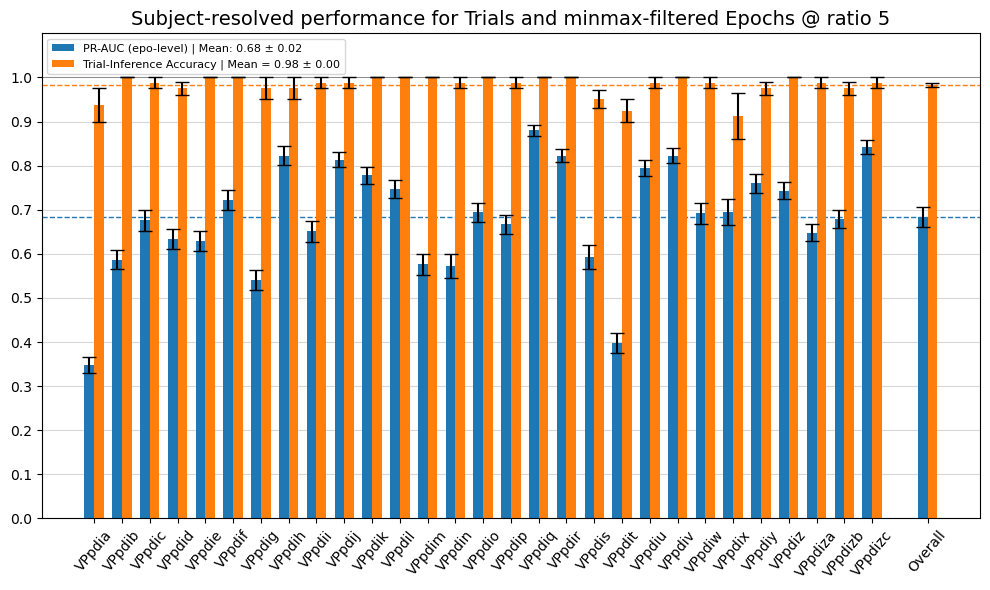

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
task = 'covert'


subjects_data = results_decoding["subjects"]

# --- Extract data fields for plotting ---
subject_ids = [subject['subject_id'] for subject in subjects_data]
pr_auc_means = [subject['pr_auc_mean'] for subject in subjects_data]
pr_auc_ses = [subject['pr_auc_se'] for subject in subjects_data]
correct_trials_means = [subject['correct_trials_mean'] for subject in subjects_data]
correct_trials_ses = [subject['correct_trials_se'] for subject in subjects_data]

# --- Plotting ---
x = np.arange(len(subject_ids))
x[-1] += 1  # create a visual gap.
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 6))


# Customize plot labels and title
acc_mean = np.mean(correct_trials_means)
acc_se = np.std(correct_trials_means, ddof=1) / np.sqrt(len(correct_trials_means))

prauc_mean = np.mean(pr_auc_means)
prauc_se = np.std(pr_auc_means, ddof=1) / np.sqrt(len(pr_auc_means))

# Bar plot for PR-AUC with error bars
pr_auc_bars = ax.bar(x - width/2, pr_auc_means, width, yerr=pr_auc_ses,
                     label=f'PR-AUC (epo-level) | Mean: {prauc_mean:.2f} ± {prauc_se:.2f}', capsize=5)

# Bar plot for Trial-Inference Accuracy with error bars
trial_acc_bars = ax.bar(x + width/2, correct_trials_means, width, yerr=correct_trials_ses,
                        label=f'Trial-Inference Accuracy | Mean = {acc_mean:.2f} ± 'f'{acc_se:.2f}', capsize=5)


ax.set_ylabel('', fontsize=12)
ax.set_title(
    f'Subject-resolved performance for Trials and minmax-filtered Epochs @ ratio {ratio_0_to_1}',
    fontsize=14
)
ax.set_xticks(x)
ax.set_xticklabels(subject_ids, fontsize=10, rotation=50)
ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.1))

# Add horizontal reference lines
ax.axhline(y=1, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axhline(y=np.mean(pr_auc_means), color='tab:blue', linestyle='--', linewidth=1,
            zorder=0, label = f'')
ax.axhline(y=np.mean(correct_trials_means), color='tab:orange', linestyle='--',
            linewidth=1, zorder=0)

# Additional formatting for grid and legend
ax.grid(alpha=0.5, axis='y')
ax.set_axisbelow(True)
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()

# --- Save the plot ---
save_dir = join(p300_dir, "plots", "decoding")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
#plt.savefig(join(save_dir, f"{task}_lda_p300_results.png"), dpi=300)
#plt.savefig(join(save_dir, f"{task}_lda_p300_results.svg"), dpi=300)

plt.plot()
